In [2]:
# import pandana as pdna
import quilt3
import os
import pandana as pdna
from geosnap import Community
%matplotlib inline

Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 2516.38entries/s]
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.spectral module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 1396.55entries/s]


The networks can take awhile to download and process from OSM, but we have pre-built networks for every metro in the country stored in our quilt bucket

In [3]:
if not os.path.exists("../data/12580.h5"):
    p = quilt3.Package.browse('osm/metro_networks_8k', 's3://spatial-ucr')
    p['12580.h5'].fetch("../data/")

In [4]:
balt = Community.from_lodes(msa_fips='12580')

Loading manifest: 100%|██████████| 52/52 [00:00<00:00, 23606.86entries/s]
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
gdf = balt.gdf

In [8]:
gdf.columns

Index(['geoid', 'year', 'CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05', 'CFS01',
       'CFS02', 'CFS03', 'CFS04', 'CFS05', 'create_date', 'earnings_1251_3333',
       'earnings_over_3333', 'earnings_under_1250', 'education_bachelors',
       'education_hs', 'education_lths', 'education_some_college',
       'employees_30_54', 'employees_55plus', 'employees_asian',
       'employees_black', 'employees_female', 'employees_hawaiian_pi',
       'employees_hispanic', 'employees_male', 'employees_native_american',
       'employees_not_hispanic', 'employees_twoplus_races',
       'employees_under_30', 'employees_white', 'geometry', 'housing_units',
       'naics_11', 'naics_21', 'naics_22', 'naics_23', 'naics_31_33',
       'naics_42', 'naics_44_45', 'naics_48_89', 'naics_51', 'naics_52',
       'naics_53', 'naics_54', 'naics_55', 'naics_56', 'naics_61', 'naics_62',
       'naics_71', 'naics_72', 'naics_81', 'naics_90', 'population',
       'total_employees'],
      dtype='object')

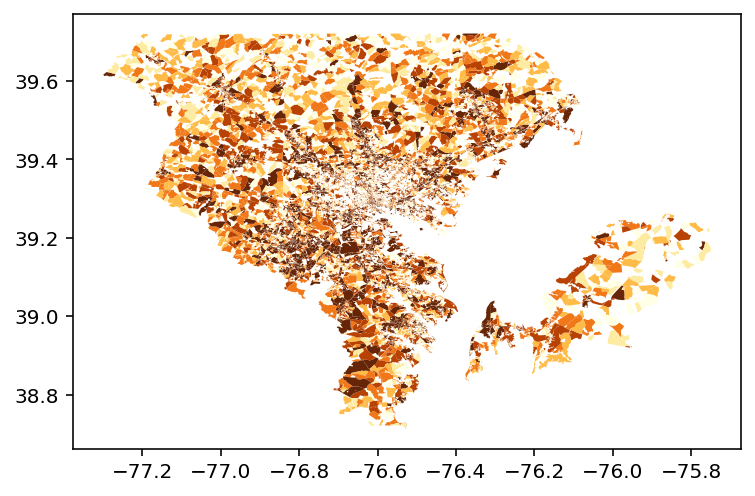

In [9]:
gdf.dropna(subset=['total_employees']).plot(column='total_employees', scheme='quantiles', k=6, cmap='YlOrBr')

In [10]:
net = pdna.Network.from_hdf5("../data/12580.h5")

In [8]:
net.precompute(3000)

Here we're doing a KNN to get the intersection node nearest to each block centroid

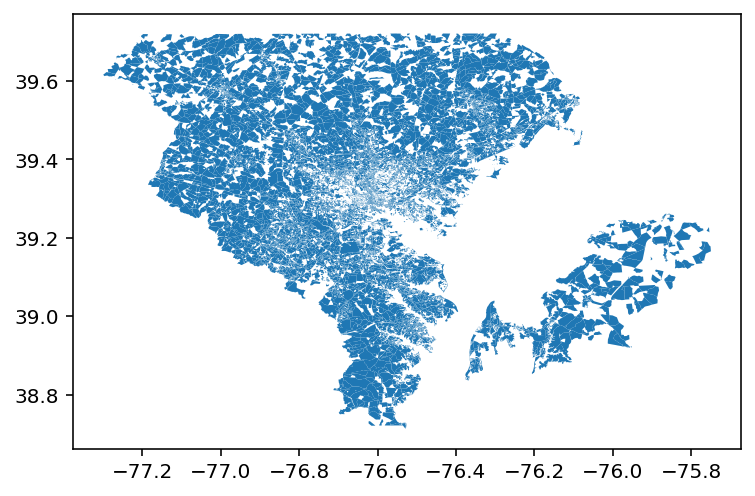

In [21]:
gdf.plot()

In [17]:
gdf["node_ids"] = net.get_node_ids(gdf.centroid.x,
                                   gdf.centroid.y)

In [23]:
gdf

,geoid,year,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,...,naics_56,naics_61,naics_62,naics_71,naics_72,naics_81,naics_90,population,total_employees,node_ids
0,240037022042002,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,228,2,102607743
1,240037403031002,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,136,3,2143247725
2,240037410002003,2015,0,0,0,0,0,0,0,0,...,0,0,11,0,0,0,0,0,11,102558905
3,240037313081006,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,149,1,102622897
4,240037313072005,2015,0,0,0,0,0,0,0,0,...,1,0,42,0,0,2,0,759,63,3796336740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15358,245102713001012,2015,0,0,0,0,0,0,0,0,...,0,68,1,0,18,4,0,147,101,2324760817
15359,245100104002016,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,16,21,2407881897
15360,245100301002007,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,5749632825
15361,245102705014010,2015,0,0,0,0,0,0,0,0,...,4,5,3,0,0,0,0,38,12,5282287945


Then, create a new veraiable on the network (total employees) located on the nodes we just identified, with values equal to total_employees

In [24]:
net.set(gdf.node_ids, variable=gdf["total_employees"], name="total_employees")

Now calculate shortest distance between every node in the network and add up all the jobs accessible within 2km. This will give back a series for every node on the network. Using this series, we can  move up or down levels of the hierarchy by taking the nearest intersection node to any polygon

In [25]:
access = net.aggregate(2500, type="sum", name="total_employees")

In [29]:
access

id
234661        0.0
246574        0.0
275232        0.0
275233        0.0
275234        0.0
             ... 
6571039279    0.0
6571039280    0.0
6571039296    0.0
6571039306    0.0
6571039323    0.0
Name: emp, Length: 694573, dtype: float64

In [28]:
access.name ='emp'

In [30]:
gdf = gdf.merge(access, left_on='node_ids', right_index=True)

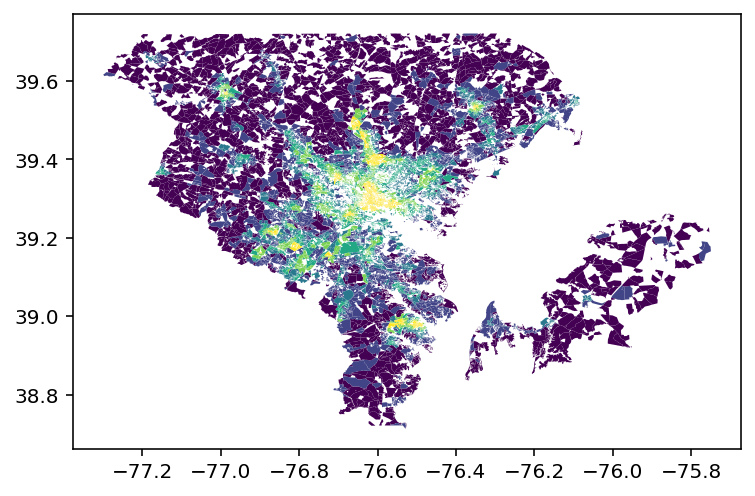

In [31]:
gdf.plot(column='emp', scheme='quantiles', k=6)

In [32]:
tracts = Community.from_census(msa_fips='12580', years=[2010])

/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [33]:
tgdf = tracts.gdf

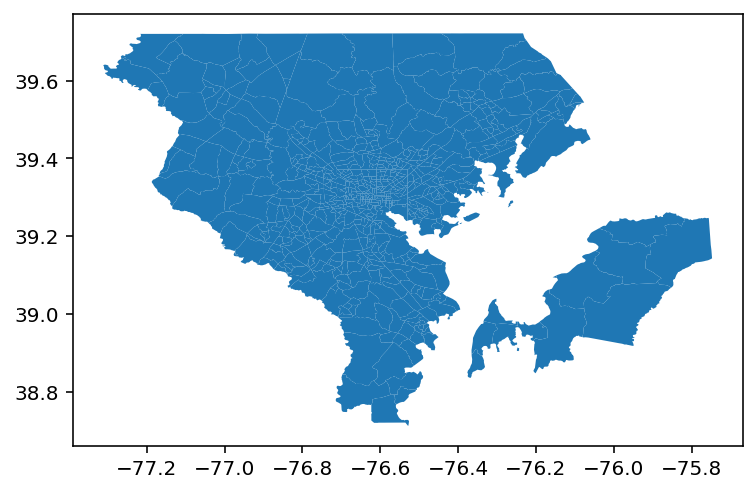

In [34]:
tgdf.plot()

now we'll grab the nearest intersection node for each tract and plot *tract*-level access

In [35]:
tgdf["node_ids"] = net.get_node_ids(tgdf.centroid.x, tgdf.centroid.y)

In [36]:
tgdf=tgdf.merge(access, left_on='node_ids', right_index=True)

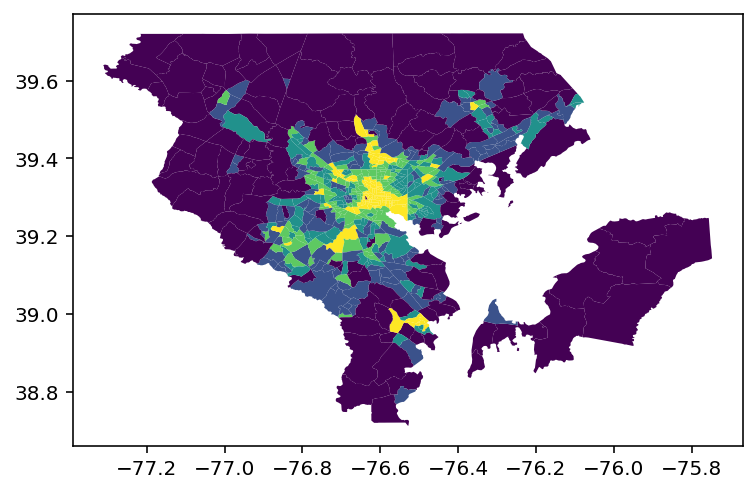

In [37]:
tgdf.plot('emp', scheme="quantiles", k=5)

The idea then would be to identify employment centers at some density cutoff (e.g. everything in yellow), then drop out anything that doesnt meet the total employment threshold
  
e.g. do something like

- select all tracts where access>= `density_threshold`
- dissolve tract boundaries to give you contiguous employment center polys
- select all emp centers where total employment >= `total_threshold`

In [38]:
centers = tgdf[tgdf.emp >=9000]

Here are our employment centers in Baltimore (based on the accessibility threshold alone)

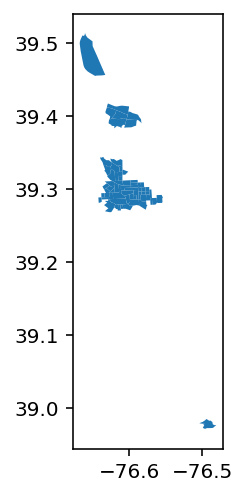

In [39]:
centers.plot()

I dont think geopandas has a generic dissolve that groups contiguous objects...  you have to supply a grouping column, so we need to create one. Simple with a `W`

In [23]:
from libpysal.weights import Queen

In [24]:
w = Queen.from_dataframe(centers)

/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 31, 58.
  warnings.warn(message)


In [25]:
w.component_labels

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0], dtype=int32)

In [26]:
centers['labels'] = w.component_labels

/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
centers=centers.dissolve(aggfunc='sum', by='labels')

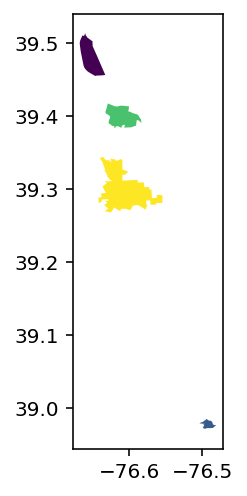

In [28]:
centers.plot('emp', scheme='quantiles', k=8)

In [29]:
centers.emp

labels
0    1.550491e+06
1    8.123502e+04
2    1.115304e+04
3    9.634751e+03
Name: emp, dtype: float64